## 2. Análisis de Sentimiento

Implementación y evaluación de un modelo de análisis de sentimiento.

El objetivo principal es el de realizar un **modelo de clasificación binaria**. Se valorará positivamente comparar la variación en los resultados al usar **diferentes modelos**, al **modificar algún paso en la etapa de preprocesado** (stemming vs no stemming, p.ej.), así como la comparación de resultados utilizando o bien **modelos pre-entrenados** o modelos más simples (como VADER).

Se utilizará alguno de los datasets disponibles de **reviews de Amazon**.

Importamos las librerías y funciones que vamos a necesitar.

In [1]:
import pandas as pd
import numpy as np
import random
import os
import unicodedata
import string

import warnings
warnings.filterwarnings('ignore')

from stop_words import get_stop_words
from num2words import num2words

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

In [29]:
#Función que nos devuelve el diccionario de lemas que se usará para lematizar el texto.
def get_lemmas_dict(data_path, lemmas_dict_file):
    
    lemmas_dict = {}
    
    with open(os.path.join(data_path, lemmas_dict_file), 'r', encoding='utf-8') as f:
        for line in f:
            (key, val) = line.split()
            lemmas_dict[str(val)] = key
            
    return lemmas_dict

In [32]:
#Función que hace el preprocesado del texto: normalizar y lematizar en base a un diccionario de lemas que se le pasa.
def text_normalizer(text, lemmas_dict):
    
    processed_text = []
    
    # Convierte el texto a minúsuculas
    text = text.lower()
    
    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tabla para eliminar signos de puntuación
    table = str.maketrans('', '', string.punctuation)
    
    # Segmentar texto en frases
    sentences = text.split('.')
    
    # Lematizar: para cada frase
    for sentence in sentences:
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            if word not in string.punctuation:  
                word = word.translate(table)
                word = lemmas_dict.get(word, word)
                if word.isdigit():
                    word = num2words(word, lang='en')
            processed_text.append(word)
    
    return ' '.join(processed_text)
    

In [16]:
#Función que asigna el sentimiento a la valoración de la review
def label_sentiment(row):
    
    if int(row['overall']) < 3.1:
        return 'neg'
    else:
        return 'pos'

### CARGA DE DATOS

Leemos los datos de entrada, que en este caso son reviews de Amazon.

Vamos a tomar 4 categorías: 

- "Automotive" 
- "Musical Instruments" 
- "Office Products" 
- "Patio, Lawn and Garden"

In [2]:
automotive = pd.read_json('./datasets/Automotive_5.json', lines= True)
instruments = pd.read_json('./datasets/Musical_Instruments_5.json', lines= True)
office = pd.read_json('./datasets/Office_Products_5.json', lines= True)
garden = pd.read_json('./datasets/Patio_Lawn_and_Garden_5.json', lines= True)

print(f'Dimensiones del dataset de automotive: {automotive.shape}')
print(f'Dimensiones del dataset de instruments: {instruments.shape}')
print(f'Dimensiones del dataset de office: {office.shape}')
print(f'Dimensiones del dataset de garden: {garden.shape}')

Dimensiones del dataset de automotive: (20473, 9)
Dimensiones del dataset de instruments: (10261, 9)
Dimensiones del dataset de office: (53258, 9)
Dimensiones del dataset de garden: (13272, 9)


de cada categoría nos quedamos con 10.000 muestras

In [3]:
#cogemos subsets de 10.000 muestras de cada categoría
redAutomotive = automotive.sample(10000)
redInstruments = instruments.sample(10000)
redOffice = office.sample(10000)
redGarden = garden.sample(10000)

#concatenamos todos los subsets
df = pd.concat([redAutomotive, redInstruments, redOffice, redGarden])
#removemos el dataframe para desordenar los subsets anteriores
df = df.sample(frac=1)

print(f'Dimensiones del dataset completo: {df.shape}')
df.head()

Dimensiones del dataset completo: (40000, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
4555,A3NI8JZCL7BZMC,B000EEJ8IM,John S.,"[0, 0]",Make sure you order the right size! I don't us...,5,great sustains,1373155200,"07 7, 2013"
19718,A35BH7OZJZJE2L,B00B1VBQRS,"Bark Twain ""stonesculptor""","[0, 0]",Used this to keep gas stabilized over the wint...,5,Fuel stabilizer,1389139200,"01 8, 2014"
3956,AHUCLL02HS7M5,B0009EQOES,Alex Bartlett,"[0, 0]","This strap works well, looks good, and is comf...",5,Useful product with color options,1387497600,"12 20, 2013"
4435,AZV26LP92E6WU,B000S61YO2,"M. Hammond ""ColemanFlGuy""","[0, 0]",i was very patient and practiced a lot of hole...,5,worked great for me,1398211200,"04 23, 2014"
4310,A2CSE0O1AJWUU5,B000BGHVSM,D. Parent,"[1, 1]",I bought this jack stand to replace the assort...,2,Tongue Jack Stand - light duty,1378080000,"09 2, 2013"


In [4]:
# eliminamos todas las columnas que no vamos a usar
not_useful_columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime','reviewTime']
df.drop(not_useful_columns, axis=1, inplace=True)

print(f'Dimensiones del dataset completo: {df.shape}')
df.head()

Dimensiones del dataset completo: (40000, 2)


,reviewText,overall
4555,Make sure you order the right size! I don't us...,5
19718,Used this to keep gas stabilized over the wint...,5
3956,"This strap works well, looks good, and is comf...",5
4435,i was very patient and practiced a lot of hole...,5
4310,I bought this jack stand to replace the assort...,2


asignamos un sentimiento negativo o positivo en función de la valoración. En este caso estamos ante un ejercicio de aprendizaje supervisado donde ya sabemos si la etiqueta de sentimiento es positivo o negativo.

In [6]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df.head()

,reviewText,overall,sentiment_label
4555,Make sure you order the right size! I don't us...,5,pos
19718,Used this to keep gas stabilized over the wint...,5,pos
3956,"This strap works well, looks good, and is comf...",5,pos
4435,i was very patient and practiced a lot of hole...,5,pos
4310,I bought this jack stand to replace the assort...,2,neg


In [7]:
df['sentiment_label'].describe()

count     40000
unique        2
top         pos
freq      33880
Name: sentiment_label, dtype: object

Vemos que estamos trabajando con un dataset muy desbalanceado a pesar de haber considerado la valoración de 3 estrellas como negativa. Las reviews de 3 estrellas son del orden de 4000, mientras que la suma de 4 y 5 estrellas es de más de 33000.

Ahora hacemos la separación de nuestros conjuntos de trabajo: train, validation and test. La idea es entrenar los distintos modelos con los que vamos a trabajar con el bloque de train. A continuación los validaremos con el conjunto de validation y por último, cuando ya tengamos elegido nuestro modelo final lo evaluamos con el dataset de test.

Y teniendo en cuenta el desbalanceo anteriormente citado usamos la opción de stratify para mantener las mismas proporciones en cada bloque.

In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.8,
    random_state=7,
    shuffle=True,
    stratify=df['sentiment_label']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    train_size=0.75,
    random_state=7,
    shuffle=True,
    stratify=y_train_full
)



### EXTRACCIÓN DE FEATURES


**1.- VALORES POR DEFECTO**

Como podemos ver en el resultado de la siguiente celda estamos usando los valores por defecto, así que el preprocesado es mínimo, simplemente se pasa a minúsculas.

In [9]:
countVect = TfidfVectorizer()
countVect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [10]:
X_train_ = countVect.transform(X_train)
X_val_ = countVect.transform(X_val)
X_test_ = countVect.transform(X_test)

Hacemos una regresión logística para predecir el sentimiento de la review.
En concreto vamos a hacer un barrido del parámetro C, que nos indica la regularización que aplicamos (valores más pequeños equivalen a regularización más fuerte).

Accuracy for C=0.001: train 0.847 val 0.847
Accuracy for C=0.005: train 0.847 val 0.847
Accuracy for C=0.01: train 0.847 val 0.847
Accuracy for C=0.05: train 0.847 val 0.847
Accuracy for C=0.1: train 0.847 val 0.847
Accuracy for C=0.5: train 0.871 val 0.861
Accuracy for C=1: train 0.89 val 0.868
Accuracy for C=10: train 0.956 val 0.871
Accuracy for C=100: train 0.998 val 0.856
Accuracy for C=1000: train 1.0 val 0.845


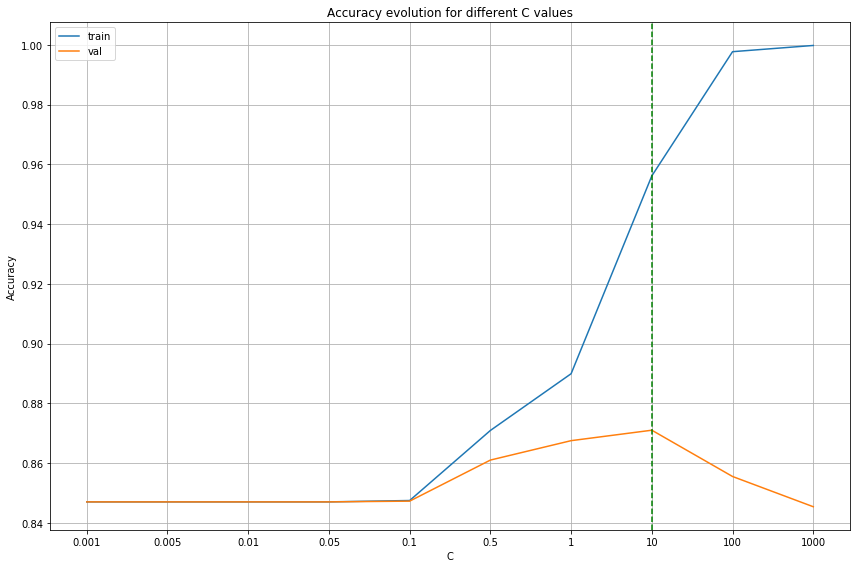

In [11]:
c_params = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000]

train_acc = list()
val_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    val_predict = lr.predict(X_val_)
    
    print ("Accuracy for C={}: train {} val {}".format(c, 
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))

    
    train_acc.append(accuracy_score(y_train, train_predict))
    val_acc.append(accuracy_score(y_val, val_predict))
    
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.axvline(np.argmax(val_acc), c='g', ls='--')
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

A simple vista destaca que para valores muy altos de C apenas existe regularización y por tanto el overfitting es mayor.

En concreto para nuestra gráfica vemos que el valor máximo en validación lo obtenemos con C=10, pero podemos decir que el valor óptimo sería 1 ó 0.5, ya que en 10 empezamos a tener un overfitting muy importante (el modelo se aprende muy bien los datos de train pero luego no lo generaliza tan bien) y sin embargo los valores de accuracy varían muy poco (tomando C = 1 ó 0.5). 

In [12]:
copt=0.5
lr = LogisticRegression(C=copt, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
val_predict = lr.predict(X_val_)

print ("Accuracy for Copt={}: train {} val {}".format(copt,  
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))


print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, val_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, val_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, val_predict)))

Accuracy for Copt=0.5: train 0.871 val 0.861
Confussion matrix:
[[ 162 1062]
 [  50 6726]]

Classification report:
              precision    recall  f1-score   support

         neg       0.76      0.13      0.23      1224
         pos       0.86      0.99      0.92      6776

    accuracy                           0.86      8000
   macro avg       0.81      0.56      0.57      8000
weighted avg       0.85      0.86      0.82      8000

Accuracy score:0.861


Con estos datos podemos ver que la mayoría de las veces predice que el sentimiento es positivo. Al tratarse de un dataset desbalanceado acierta casi todas las veces. No obstante tenemos mucho margen de mejora, así que vamos a ir haciendo pruebas.

A modo de ejemplo podemos visualizar para una determinada review las palabras con mayor y menor TF-IDF:

In [13]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 12089
Sentiment: pos
Review: I've been using this product in tandem with Poison Peanuts Pellets.  Between them, my chipmunk problem seems to have abated.


In [14]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=countVect.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 12089:
             tfidf
abated    0.457102
chipmunk  0.377711
tandem    0.377711
peanuts   0.334187
pellets   0.324813
poison    0.286034
between   0.196354
seems     0.164019
problem   0.163893
been      0.141512

Top 10 words with lowest TF_IDF in the review 12089:
            tfidf
using    0.132752
ve       0.132701
product  0.127537
them     0.112763
have     0.078885
with     0.076190
my       0.076046
in       0.072438
this     0.063377
to       0.055632


Ahora vamos a analizar los valores chi-cuadrado de las palabras del bloque de train. De esta forma veremos las palabras que menos balanceadas están en ambos sentimientos, es decir, las palabras que mejor definen cada una de las dos predicciones que estamos buscando.

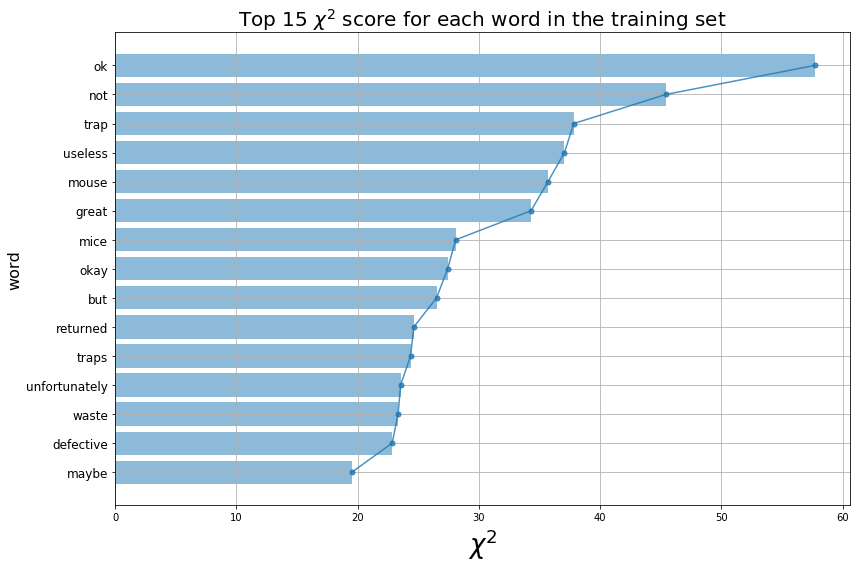

In [15]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(countVect.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

viendo estos últimos resultados observamos cómo lematizar y usar stop_words nos puede ayudar. El objetivo es reducir el número de palabras y quedarnos con aquellas que aporten más valor a la hora de distinguir si el sentimiento es positivo o negativo.


**2.- AÑADIMOS STOP_WORDS Y LEMATIZAMOS**

Ahora nos creamos una lista de stop_words que pasaremos al Count Vectorizer y además usamos un diccionario de lemas que pasamos a la función text_normalizer, donde además aprovechamos para hacer algo más de preprocesado como:
- convertir el te texto a minúsuculas
- eliminar caracteres "extraños"
- eliminar signos de puntuación
- segmentar el texto en frases y lematizar a nivel de palabra

In [39]:
sw_list = get_stop_words('en')
#print(sw_list)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [30]:
data_path = './data'
lemmas_dict_file = 'lemmatization-en.txt'

lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)
#lemmas_dict

In [20]:
X_train = X_train.apply(lambda row: text_normalizer(row, lemmas_dict))
X_val = X_val.apply(lambda row: text_normalizer(row, lemmas_dict))
X_test = X_test.apply(lambda row: text_normalizer(row, lemmas_dict))

In [21]:
countVect = TfidfVectorizer(
    stop_words=sw_list)
countVect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'all', 'am', 'an', 'and', 'any', 'are', "aren't",
                            'as', 'at', 'be', 'because', 'been', 'before',
                            'being', 'below', 'between', 'both', 'but', 'by',
                            "can't", 'cannot', 'could', "couldn't", 'did', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [22]:
X_train_ = countVect.transform(X_train)
X_val_ = countVect.transform(X_val)
X_test_ = countVect.transform(X_test)

Accuracy for C=0.001: train 0.847 val 0.847
Accuracy for C=0.005: train 0.847 val 0.847
Accuracy for C=0.01: train 0.847 val 0.847
Accuracy for C=0.05: train 0.847 val 0.847
Accuracy for C=0.1: train 0.847 val 0.848
Accuracy for C=0.5: train 0.867 val 0.859
Accuracy for C=1: train 0.882 val 0.867
Accuracy for C=10: train 0.946 val 0.87
Accuracy for C=100: train 0.992 val 0.844
Accuracy for C=1000: train 1.0 val 0.825


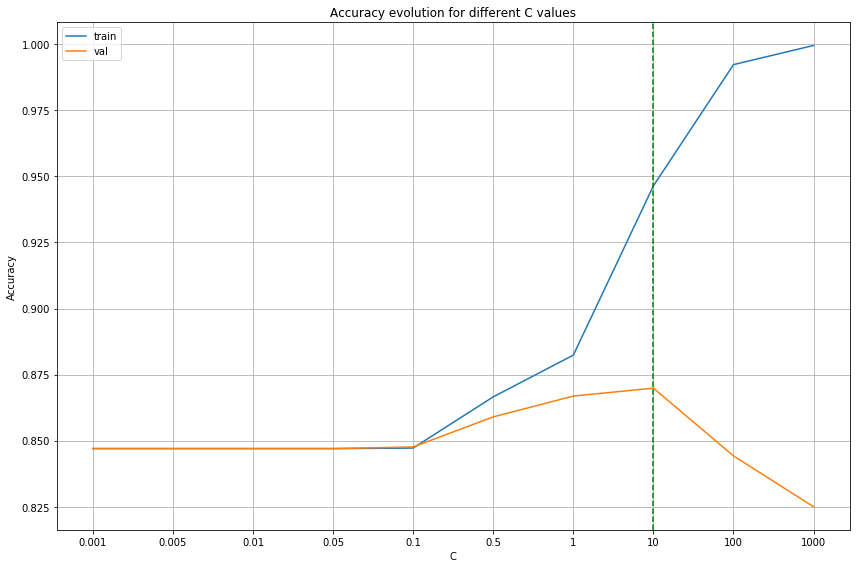

In [23]:
c_params = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000]

train_acc = list()
val_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    val_predict = lr.predict(X_val_)
    
    print ("Accuracy for C={}: train {} val {}".format(c, 
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))

    
    train_acc.append(accuracy_score(y_train, train_predict))
    val_acc.append(accuracy_score(y_val, val_predict))

    
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.axvline(np.argmax(val_acc), c='g', ls='--')
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [24]:
copt=0.5
lr = LogisticRegression(C=copt, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
val_predict = lr.predict(X_val_)

print ("Accuracy for Copt={}: train {} val {}".format(copt,  
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))


print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, val_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, val_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, val_predict)))

Accuracy for Copt=0.5: train 0.867 val 0.859
Confussion matrix:
[[ 141 1083]
 [  45 6731]]

Classification report:
              precision    recall  f1-score   support

         neg       0.76      0.12      0.20      1224
         pos       0.86      0.99      0.92      6776

    accuracy                           0.86      8000
   macro avg       0.81      0.55      0.56      8000
weighted avg       0.85      0.86      0.81      8000

Accuracy score:0.859


Si comparamos los resultados con la primera simulación, vemos que son prácticamente similares. Esto se debe principalmente a que el dataset está muy desbalanceado y casi siempre predice sentimiento positivo.

A continuación, por mantener los mismos ejemplos que vimos antes, visualizamos las palabras más destacadas para una review concreta y las que tienen mayor chi-cuadrado:

In [25]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 14791
Sentiment: pos
Review: this pick be nice and thin just what i be look for in a pick   they seem durable so far and the light color make them easy to see when you drop one or set it down   im satisfy with this pick 


In [26]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=countVect.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 14791:
            tfidf
pick     0.644072
satisfy  0.294309
drop     0.253796
durable  0.247020
thin     0.245312
color    0.187141
light    0.183789
far      0.182559
set      0.175070
seem     0.162157

Top 10 words with lowest TF_IDF in the review 14791:
         tfidf
set   0.175070
seem  0.162157
im    0.161768
see   0.157191
nice  0.156530
look  0.145038
easy  0.131204
make  0.122628
just  0.119726
one   0.104255


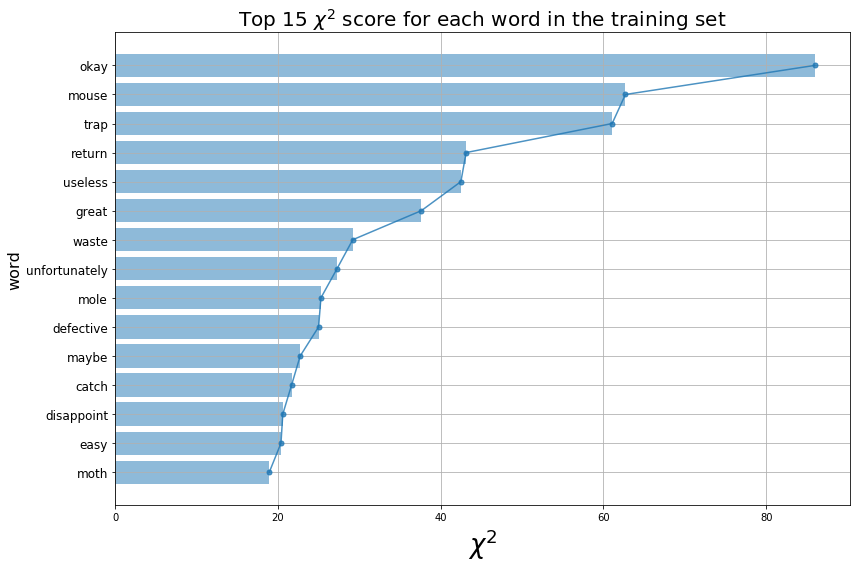

In [27]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(countVect.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [28]:
print(len(countVect.vocabulary_))

43852


A pesar de haber quitado stop_words y haber lematizado, las palabras que vemos en esta última gráfica siguen siendo prácticamente las mismas. Esto se debe a que estamos usando todas las palabras, 43852. En el siguiente paso vamos a probar a reducir nuestro léxico.

**3.- REDUCIMOS EL NÚMERO DE PALABRAS**

En este caso de las 43852 palabras totales vamos a quitar las que no se repitan un mínimo de 5 veces y además solo nos vamos a quedar con las 5000 más usadas. Hay que recordar que seguimos usando la lista de stop_words y el preprocesado del punto anterior.

In [34]:
countVect = TfidfVectorizer(
    min_df=5,
    max_features=5000,
    stop_words=sw_list)
countVect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'all', 'am', 'an', 'and', 'any', 'are', "aren't",
                            'as', 'at', 'be', 'because', 'been', 'before',
                            'being', 'below', 'between', 'both', 'but', 'by',
                            "can't", 'cannot', 'could', "couldn't", 'did', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [35]:
X_train_ = countVect.transform(X_train)
X_val_ = countVect.transform(X_val)
X_test_ = countVect.transform(X_test)

Accuracy for C=0.001: train 0.847 val 0.847
Accuracy for C=0.005: train 0.847 val 0.847
Accuracy for C=0.01: train 0.847 val 0.847
Accuracy for C=0.05: train 0.847 val 0.847
Accuracy for C=0.1: train 0.847 val 0.848
Accuracy for C=0.5: train 0.868 val 0.86
Accuracy for C=1: train 0.881 val 0.869
Accuracy for C=10: train 0.918 val 0.868
Accuracy for C=100: train 0.939 val 0.843
Accuracy for C=1000: train 0.949 val 0.822


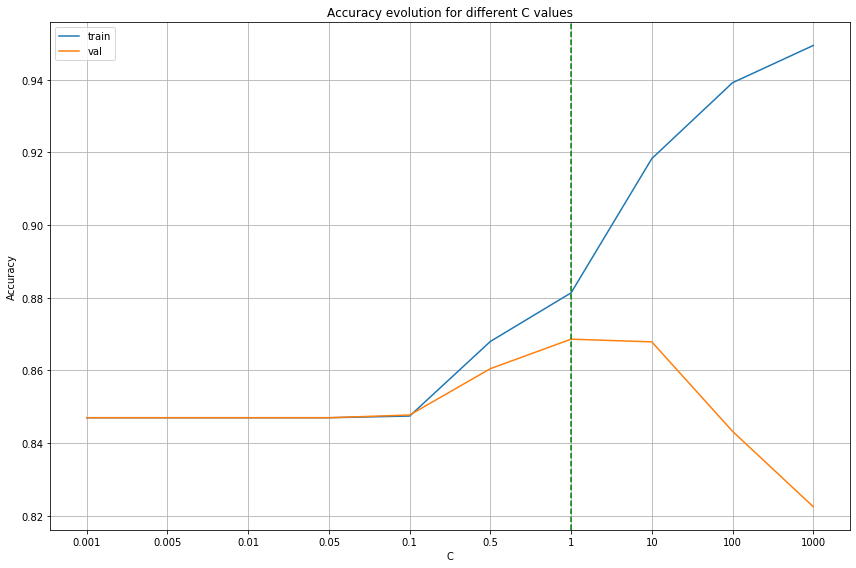

In [36]:
c_params = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000]

train_acc = list()
val_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    val_predict = lr.predict(X_val_)
    
    print ("Accuracy for C={}: train {} val {}".format(c, 
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))

    
    train_acc.append(accuracy_score(y_train, train_predict))
    val_acc.append(accuracy_score(y_val, val_predict))

    
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.axvline(np.argmax(val_acc), c='g', ls='--')
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Para este modelo tomamos como Copt 1, ya que es el valor máximo en validación y la diferencia con train es muy parecida a 0.5.

In [37]:
copt=1
lr = LogisticRegression(C=copt, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
val_predict = lr.predict(X_val_)

print ("Accuracy for Copt={}: train {} val {}".format(copt,  
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))


print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, val_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, val_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, val_predict)))

Accuracy for Copt=1: train 0.881 val 0.869
Confussion matrix:
[[ 267  957]
 [  94 6682]]

Classification report:
              precision    recall  f1-score   support

         neg       0.74      0.22      0.34      1224
         pos       0.87      0.99      0.93      6776

    accuracy                           0.87      8000
   macro avg       0.81      0.60      0.63      8000
weighted avg       0.85      0.87      0.84      8000

Accuracy score:0.868625


Analizando los resultados vemos que en esta caso mejoramos un poco las prestaciones. Para analizar de forma conjunta la precision y el recall vamos a fijarnos en el f-1 score. Si en los modelos anteriores teníamos valores de 0.23 y 0.92 ahora tenemos 0.34 y 0.93. Tomamos como referencia el macro average y nos quedamos en el 63%, cuando antes teníamos un 57%.

Como en casos anteriores, visualizamos el ejemplo para una review y las palabaras con mayor chi-cuadrado:

In [ ]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

In [38]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=countVect.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 15:
             tfidf
smoker    0.548842
smoke     0.304774
weber     0.231798
charcoal  0.160996
rain      0.152757
electric  0.144693
meat      0.141878
salt      0.128425
water     0.115844
recipe    0.111388

Top 10 words with lowest TF_IDF in the review 15:
         tfidf
year  0.013420
want  0.013233
keep  0.013189
nice  0.013005
buy   0.011774
well  0.011708
need  0.011336
will  0.010307
make  0.010189
work  0.009327


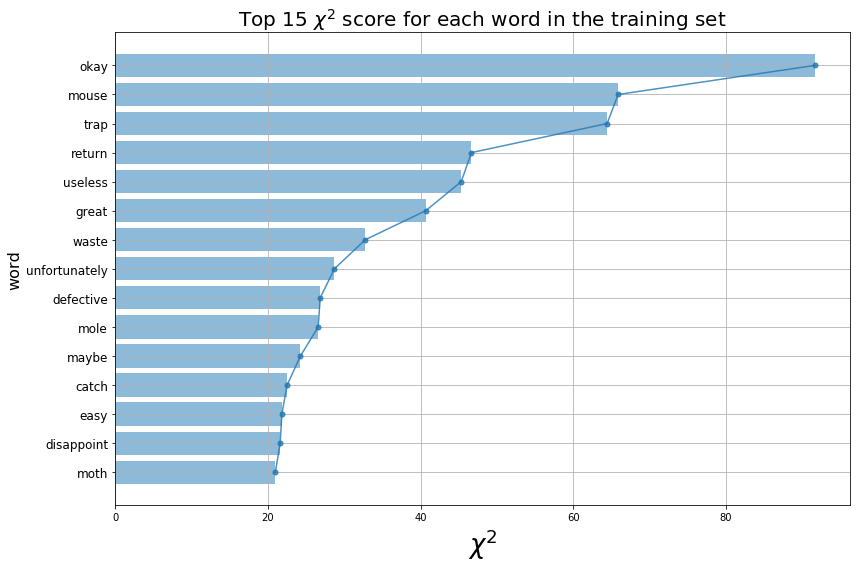

In [39]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(countVect.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [40]:
print(len(countVect.vocabulary_))

5000


Vemos que el vocabulario ha bajado a 5000 palabras, sin embargo las que más se usan para distinguir una clase de la otra (chi-cuadrado) siguen siendo las mismas. Vamos a añadir una opción más, que son los n-gramas. En concreto vamos a tener en cuenta los bigramas (conjunto de dos palabras consecutivas) además de los ajustes que hemos ido añadiendo en los puntos anteriores.

**4.- AÑADIMOS BIGRAMAS**

In [42]:
countVect = TfidfVectorizer(
    min_df=5,
    max_features=5000,
    ngram_range=(1, 2),
    stop_words=sw_list)
countVect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'all', 'am', 'an', 'and', 'any', 'are', "aren't",
                            'as', 'at', 'be', 'because', 'been', 'before',
                            'being', 'below', 'between', 'both', 'but', 'by',
                            "can't", 'cannot', 'could', "couldn't", 'did', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [43]:
X_train_ = countVect.transform(X_train)
X_val_ = countVect.transform(X_val)
X_test_ = countVect.transform(X_test)

Accuracy for C=0.001: train 0.847 val 0.847
Accuracy for C=0.005: train 0.847 val 0.847
Accuracy for C=0.01: train 0.847 val 0.847
Accuracy for C=0.05: train 0.847 val 0.847
Accuracy for C=0.1: train 0.847 val 0.848
Accuracy for C=0.5: train 0.871 val 0.862
Accuracy for C=1: train 0.887 val 0.872
Accuracy for C=10: train 0.927 val 0.87
Accuracy for C=100: train 0.949 val 0.843
Accuracy for C=1000: train 0.962 val 0.816


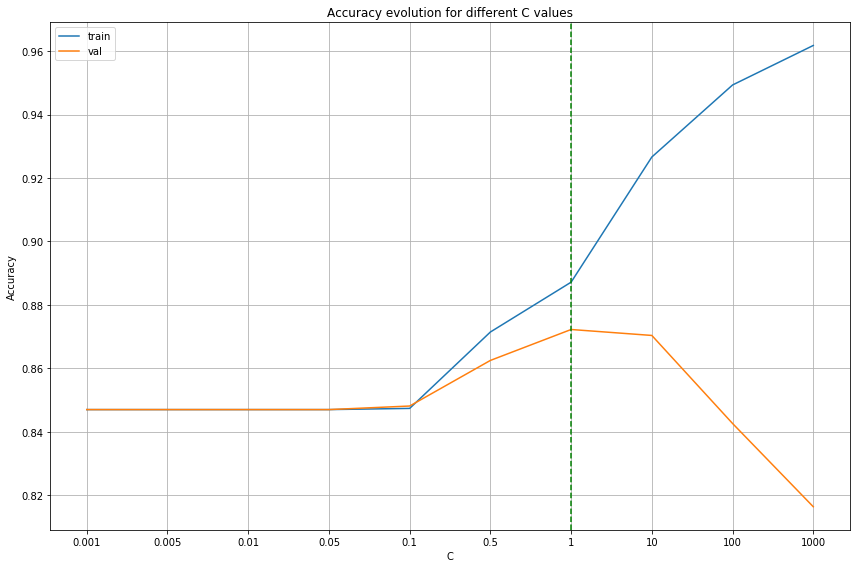

In [44]:
c_params = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000]

train_acc = list()
val_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    val_predict = lr.predict(X_val_)
    
    print ("Accuracy for C={}: train {} val {}".format(c, 
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))

    
    train_acc.append(accuracy_score(y_train, train_predict))
    val_acc.append(accuracy_score(y_val, val_predict))

    
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.axvline(np.argmax(val_acc), c='g', ls='--')
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Igual que en el punto anterior seguimos con Copt= 1.

In [45]:
copt=1
lr = LogisticRegression(C=copt, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
val_predict = lr.predict(X_val_)

print ("Accuracy for Copt={}: train {} val {}".format(copt,  
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))


print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, val_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, val_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, val_predict)))

Accuracy for Copt=1: train 0.887 val 0.872
Confussion matrix:
[[ 289  935]
 [  87 6689]]

Classification report:
              precision    recall  f1-score   support

         neg       0.77      0.24      0.36      1224
         pos       0.88      0.99      0.93      6776

    accuracy                           0.87      8000
   macro avg       0.82      0.61      0.65      8000
weighted avg       0.86      0.87      0.84      8000

Accuracy score:0.87225


Seguimos comparando los modelos de acuerdo al f1-score y si antes teníamos un 63% en el macro average ahora hemos mejorado dos puntos hasta el 65%. Se debe a que ha subido la precision y el recall en el sentimiento negativo, aunque todavía sigue teniendo unos valores muy bajos en comparación con el positivo. Como ya hemos comentado antes se debe sobre todo al desbalanceo de clases.

De nuevo, un ejemplo y las palabras o bigramas con mayor chi-cuadrado:

In [ ]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

In [46]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=countVect.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 15:
             tfidf
smoker    0.543906
smoke     0.302033
weber     0.229714
charcoal  0.159548
rain      0.151383
electric  0.143392
meat      0.140602
salt      0.127270
water     0.114802
recipe    0.110386

Top 10 words with lowest TF_IDF in the review 15:
         tfidf
year  0.013299
want  0.013114
keep  0.013071
nice  0.012888
buy   0.011668
well  0.011603
need  0.011234
will  0.010214
make  0.010097
work  0.009243


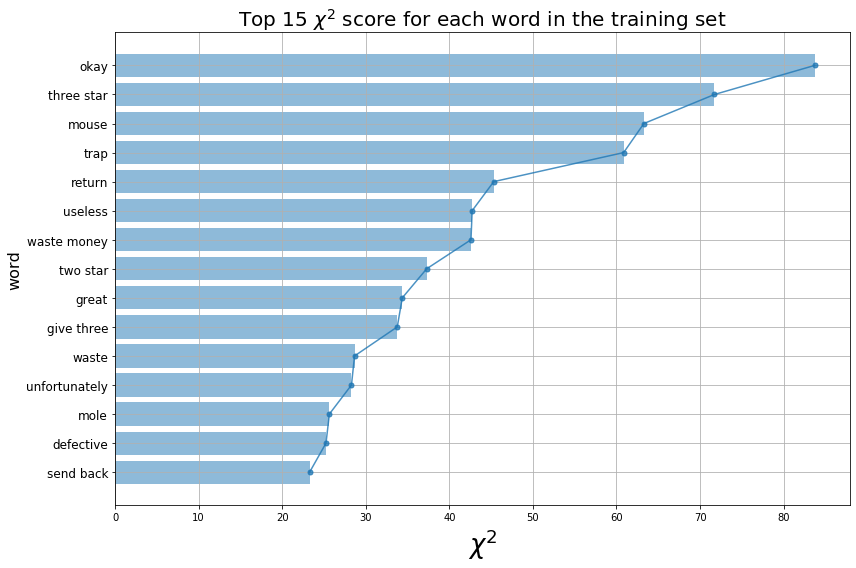

In [47]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(countVect.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Se observa a simple vista cómo han entrado varios bigramas entre elementos con mayor chi-cuadrado.

No obstante, buscando unos mejores resultados vamos a hacer la prueba a trabajar con un dataset más balanceado.

**5.- BALANCEAMOS EL DATASET**

Para ello vamos a seguir el siguiente proceso:

- nos quedamos con aquellas reviews que tengan valoración negativa (overall<3) para cada categoría.
- cogemos un número equivalente de reviews positivas (overall>3) en cada categoría.
- las unimos todas en un único dataset

In [2]:
automotive = pd.read_json('./datasets/Automotive_5.json', lines= True)
instruments = pd.read_json('./datasets/Musical_Instruments_5.json', lines= True)
office = pd.read_json('./datasets/Office_Products_5.json', lines= True)
garden = pd.read_json('./datasets/Patio_Lawn_and_Garden_5.json', lines= True)

print(f'Dimensiones del dataset de automotive: {automotive.shape}')
print(f'Dimensiones del dataset de instruments: {instruments.shape}')
print(f'Dimensiones del dataset de office: {office.shape}')
print(f'Dimensiones del dataset de garden: {garden.shape}')

Dimensiones del dataset de automotive: (20473, 9)
Dimensiones del dataset de instruments: (10261, 9)
Dimensiones del dataset de office: (53258, 9)
Dimensiones del dataset de garden: (13272, 9)


In [10]:
neg = automotive['overall'] <3
neg_automotive = automotive[neg]
neg = instruments['overall'] <3
neg_instruments = instruments[neg]
neg = office['overall'] <3
neg_office = office[neg]
neg = garden['overall'] <3
neg_garden = garden[neg]

print(f'Dimensiones del dataset de automotive: {neg_automotive.shape}')
print(f'Dimensiones del dataset de instruments: {neg_instruments.shape}')
print(f'Dimensiones del dataset de office: {neg_office.shape}')
print(f'Dimensiones del dataset de garden: {neg_garden.shape}')


Dimensiones del dataset de automotive: (1148, 9)
Dimensiones del dataset de instruments: (467, 9)
Dimensiones del dataset de office: (2856, 9)
Dimensiones del dataset de garden: (1192, 9)


In [18]:
pos = automotive['overall'] >3
pos_automotive = automotive[pos]
pos = instruments['overall'] >3
pos_instruments = instruments[pos]
pos = office['overall'] >3
pos_office = office[pos]
pos = garden['overall'] >3
pos_garden = garden[pos]


pos_automotive = pos_automotive.sample(1200)
pos_instruments = pos_instruments.sample(500)
pos_office = pos_office.sample(3000)
pos_garden = pos_garden.sample(1200)

#concatenamos todos los subsets
bal_df = pd.concat([pos_automotive, pos_instruments, pos_office, pos_garden, 
                    neg_automotive, neg_instruments, neg_office, neg_garden])
#removemos el dataframe para desordenar los subsets anteriores
bal_df = bal_df.sample(frac=1)

#eliminamos las columnas que no utilizamos
not_useful_columns = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime','reviewTime']
bal_df.drop(not_useful_columns, axis=1, inplace=True)

#etiquetamos el sentimiento
bal_df['sentiment_label'] = bal_df.apply(lambda row: label_sentiment(row), axis=1)

print(f'Dimensiones del dataset completo: {bal_df.shape}')
bal_df.head()


Dimensiones del dataset completo: (11563, 3)


,reviewText,overall,sentiment_label
1255,You will not be disappointed with any Fiskars ...,5,pos
15291,When you make as many mistakes as we make in o...,5,pos
7975,This couldn't be simpler...put it at the botto...,5,pos
9449,"Hi Folks! OK, this thing is cheap. That's cool...",1,neg
431,"This is a piece of junk.! The straps stretch, ...",1,neg


El resultado obtenido es un dataset con 11563 reviews. 

A continuación lo dividimos en train, validation and test.

In [19]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    bal_df['reviewText'],
    bal_df['sentiment_label'],
    train_size=0.8,
    random_state=7,
    shuffle=True,
    stratify=bal_df['sentiment_label']
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    train_size=0.75,
    random_state=7,
    shuffle=True,
    stratify=y_train_full
)



Aplicamos el mismo preprocesado que veníamos haciendo hasta ahora:

- stop_words
- normalizado con lematización (func text_normalizer)
- reducción de vocabulario (5000)
- añadimos bigramas.

In [33]:
X_train = X_train.apply(lambda row: text_normalizer(row, lemmas_dict))
X_val = X_val.apply(lambda row: text_normalizer(row, lemmas_dict))
X_test = X_test.apply(lambda row: text_normalizer(row, lemmas_dict))

In [34]:
countVect = TfidfVectorizer(
    min_df=5,
    max_features=5000,
    ngram_range=(1, 2),
    stop_words=sw_list)
countVect.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'all', 'am', 'an', 'and', 'any', 'are', "aren't",
                            'as', 'at', 'be', 'because', 'been', 'before',
                            'being', 'below', 'between', 'both', 'but', 'by',
                            "can't", 'cannot', 'could', "couldn't", 'did', ...],
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [35]:
X_train_ = countVect.transform(X_train)
X_val_ = countVect.transform(X_val)
X_test_ = countVect.transform(X_test)

Accuracy for C=0.001: train 0.51 val 0.51
Accuracy for C=0.005: train 0.608 val 0.589
Accuracy for C=0.01: train 0.715 val 0.687
Accuracy for C=0.05: train 0.809 val 0.773
Accuracy for C=0.1: train 0.826 val 0.782
Accuracy for C=0.5: train 0.876 val 0.809
Accuracy for C=1: train 0.895 val 0.817
Accuracy for C=10: train 0.969 val 0.807
Accuracy for C=100: train 1.0 val 0.792
Accuracy for C=1000: train 1.0 val 0.776


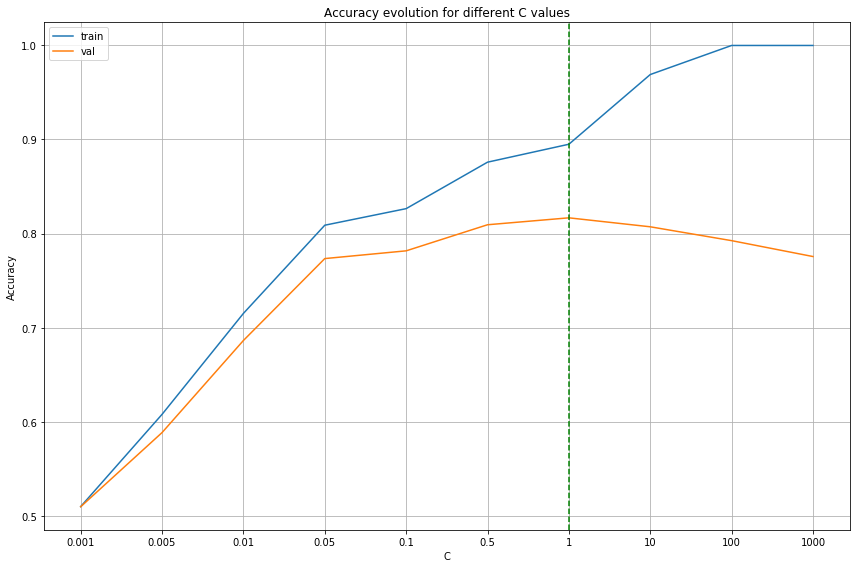

In [36]:
c_params = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 10, 100, 1000]

train_acc = list()
val_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    val_predict = lr.predict(X_val_)
    
    print ("Accuracy for C={}: train {} val {}".format(c, 
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))

    
    train_acc.append(accuracy_score(y_train, train_predict))
    val_acc.append(accuracy_score(y_val, val_predict))

    
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.axvline(np.argmax(val_acc), c='g', ls='--')
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Esta curva tiene un patrón distinto al que veníamos observando y eso nos da pie a hacer algún comentario:

- Hasta ahora teníamos una línea plana e igual en la accuracy de train y val en valores muy bajos de C (hasta 0.1 aprox). Sin embargo aquí no. Esto se debe a que este modelo tiene mayor overfitting y por tanto el parámetro C regulariza. Una de las principales razones es que tenemos menos muestras, casi la cuarta parte.

El valor máximo en validación se obtiene para C=1 y en este punto la diferencia con train respecto a C=0.5 es bastante similar, sin embargo para C=10 prácticamente se duplica, por lo que elegimos el Copt de la gráfica.

In [37]:
copt=1
lr = LogisticRegression(C=copt, solver='lbfgs', max_iter=500)
lr.fit(X_train_, y_train)

train_predict = lr.predict(X_train_)
val_predict = lr.predict(X_val_)

print ("Accuracy for Copt={}: train {} val {}".format(copt,  
        round(accuracy_score(y_train, train_predict),3), round(accuracy_score(y_val, val_predict),3)))


print('Confussion matrix:\n{}'.format(confusion_matrix(y_val, val_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_val, val_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_val, val_predict)))

Accuracy for Copt=1: train 0.895 val 0.817
Confussion matrix:
[[910 223]
 [201 979]]

Classification report:
              precision    recall  f1-score   support

         neg       0.82      0.80      0.81      1133
         pos       0.81      0.83      0.82      1180

    accuracy                           0.82      2313
   macro avg       0.82      0.82      0.82      2313
weighted avg       0.82      0.82      0.82      2313

Accuracy score:0.8166882836143536


Ahora sí obtenemos unos valores igual de altos en el sentimiento negativo que en el positivo.
Llama la atención como para casi todas las métricas tenemos resultados del 82%. En concreto, si seguimos comparando el f-1 score macro average hemos subido casi 20 puntos del 65% al 82%.

Una vez más, vemos un ejemplo para una review y los elementos con mayor chi-cuadrado:

In [38]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=countVect.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

ID: 1253
Sentiment: pos
Review: help reduce black streakseasy to installworks a advertisedput all four on in about ten minute without tool
Top 10 words with highest TF_IDF in the review 1253:
               tfidf
ten minute  0.472935
reduce      0.422292
tool        0.346176
minute      0.310604
help        0.301208
ten         0.294697
black       0.287088
without     0.259198
four        0.233483

Top 10 words with lowest TF_IDF in the review 1253:
               tfidf
ten minute  0.472935
reduce      0.422292
tool        0.346176
minute      0.310604
help        0.301208
ten         0.294697
black       0.287088
without     0.259198
four        0.233483


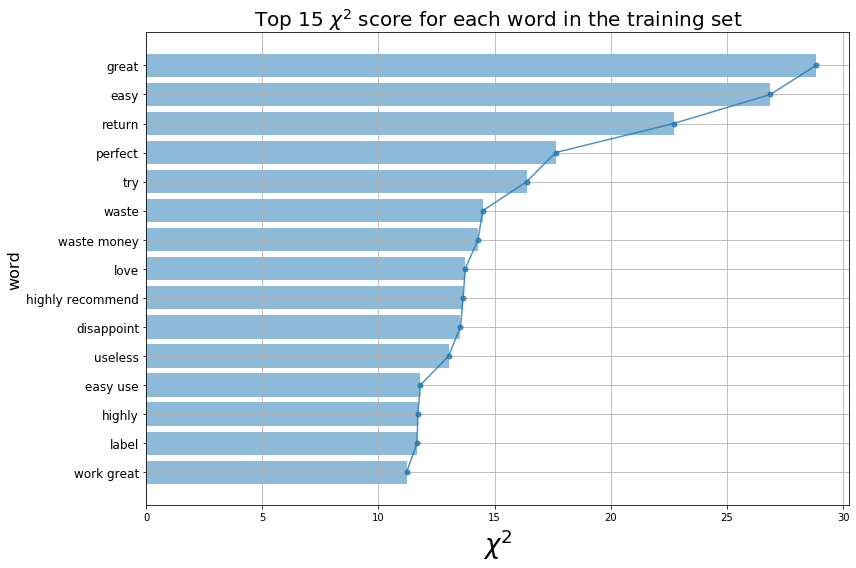

In [40]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(countVect.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

### CONCLUSIONES

Según hemos podido ir viendo en la evolución del notebook, a medida que hacíamos un preprocesado más completo o seleccionábamos mejor nuestro vocabulario (menos palabras e introducción de n-gramas) íbamos mejorando las prestaciones de nuestros modelos. 

Sin embargo estas mejoras quedaban eclipsadas por el desbalanceo existente. Al habar muchas más reviews positivas el modelo aprende bien cómo predecirlas, pero apenas tiene en cuenta a las negativas, no es capaz de diferenciarlas bien. De esta forma casi siempre predice positivo y muy pocas veces negativo.

Al haberlo balanceado se observa que el modelo es capaz de aprender y generalizar bien para ambos sentimientos y los resultados obtenidos se pueden considerar aceptables.
Por lo que se ha visto del overfitting y la regularización sería conveniente entrenar el modelo con mayor número de reviews, al igual que sería conveniente un ajuste más fino de otros parámetros:

- número total de elementos (palabras y n-gramas)
- usar el max_df para quitar un cierto porcentaje de palabaras que se usa mucho (suelen ser palabras genéricas que no aportan diferenciación entre positivio y negativo)
- usar trigramas (no solo bigramas)
- incrementar el número de muestras de entrenamiento (reviews)
